# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This dataset is related to 17 campaigns that occurred between May 2008 and November 2010 from a Portuguese bank.

During these phone campaigns, an attractive long-term deposit application, with good interest rate was offered and we would like to use machine learning techniques to find the best model and improve the campaign success rate.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
# import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import metrics
from datetime import datetime

In [2]:
# read the dataset into dataframe
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# data cleanup
# check all the unknown strings in the dataset
dfunkn = (df == 'unknown').sum()
dfu = pd.DataFrame(dfunkn, columns=['count']).reset_index()
dfu = dfu.query('count > 0').sort_values(by='count', ascending=False)
print('Before data cleanup, unknown value count =', dfu['count'].sum())
dfu

Before data cleanup, unknown value count = 12718


,index,count
4,default,8597
3,education,1731
5,housing,990
6,loan,990
1,job,330
2,marital,80


Text(0.5, 1.0, 'Unknown string count in the dataset')

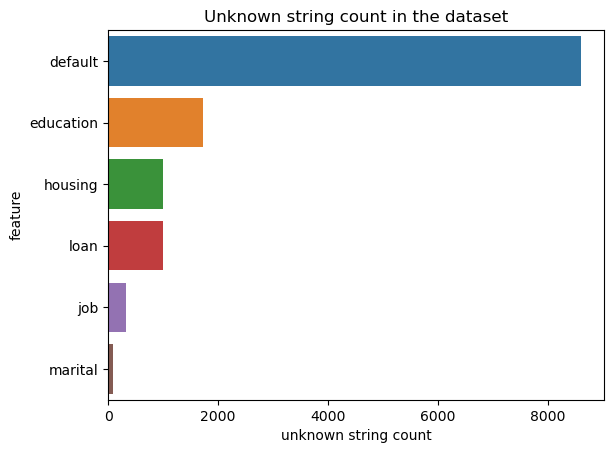

In [5]:
# display unknown strings in the dataset
sns.barplot(dfu.query('count > 0'), y='index', x='count')
plt.ylabel('feature')
plt.xlabel('unknown string count')
plt.title('Unknown string count in the dataset')

In [6]:
# clean up the dataset by dropping unknown strings
dfX = df[(df != 'unknown')].dropna()
dfuncnt = (dfX == 'unknown').sum()
print('After data cleanup, unknown value count =', dfuncnt.sum())

After data cleanup, unknown value count = 0


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Our business goal is to compare different classifiers, find the best classification model and predict what drives customers to buy the bank products.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [7]:
# display dataset info
print(dfX.info())
dfX.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 30488 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  duration        30488 non-null  int64  
 11  campaign        30488 non-null  int64  
 12  pdays           30488 non-null  int64  
 13  previous        30488 non-null  int64  
 14  poutcome        30488 non-null  object 
 15  emp.var.rate    30488 non-null  float64
 16  cons.price.idx  30488 non-null  float64
 17  cons.conf.idx   30488 non-null  floa

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000
mean,39.030012,259.484092,2.521451,956.332295,0.194273,-0.071510,93.523311,-40.602263,3.459938,5160.813409
std,10.333529,261.714262,2.720150,201.373292,0.522788,1.610399,0.585374,4.789249,1.777231,75.158065
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.313000,5099.100000
50%,37.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.856000,5191.000000
75%,45.000000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,95.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
# seperate dataset into features and the target variabl
import warnings
warnings.simplefilter('ignore', FutureWarning)

X = dfX.drop(columns=['y'])
y = dfX['y'].map({'no':0, 'yes':1})


Text(0.5, 1.0, 'Histogram of target variable distribution')

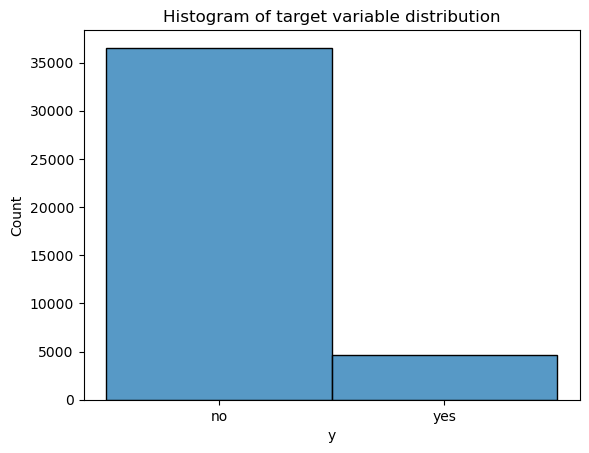

In [9]:
# show the target variable distribution
sns.histplot(df, x='y')
plt.title('Histogram of target variable distribution')

Text(0.5, 1.0, 'Histogram of data distribution by month')

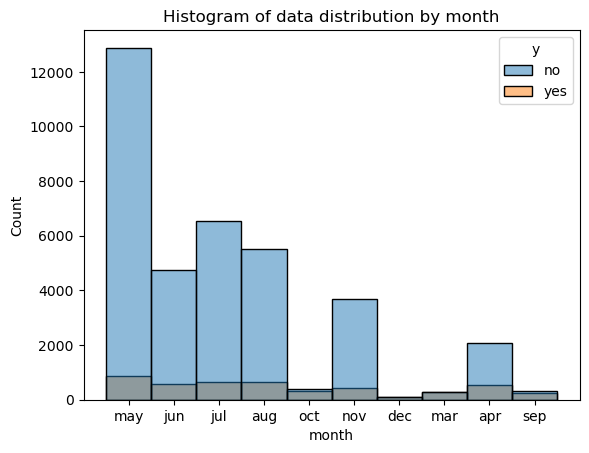

In [10]:
# show the data distribution by month
sns.histplot(df, x='month', hue='y')
plt.title('Histogram of data distribution by month')

In [11]:
# build a column transformer to encode catogorical data and scale numerical data
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

ctxfmr = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['default','job','education','contact','housing','loan','marital','month','day_of_week','poutcome']), 
    remainder=StandardScaler())
print(ctxfmr)


ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['default', 'job', 'education', 'contact',
                                  'housing', 'loan', 'marital', 'month',
                                  'day_of_week', 'poutcome'])])


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print('The training set shape =', X_train.shape)
print('The testing set shape =', X_test.shape)

The training set shape = (21341, 20)
The testing set shape = (9147, 20)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [13]:
# build a dummy classifier as our baseline
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
train_score = baseline.score(X_train, y_train)
print('Baseline dummy classifier model')
print('train accuracy =', train_score)
test_score = baseline.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, baseline.predict(X_test))
print('F1 score =', f1_score)
print('The baseline dummy classifier model just randomly guess so its F1 score = 0 even though its accuracy is 87%.')

Baseline dummy classifier model
train accuracy = 0.874138981303594
test accuracy = 0.8717612331912102
F1 score = 0.0
The baseline dummy classifier model just randomly guess so its F1 score = 0 even though its accuracy is 87%.


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [14]:
# initialize the table
models = ['LogisticRegression', 'KNN', 'DecisionTree', 'SVC']
train_time = []
train_scores = []
test_scores = []
f1_scores = []

In [15]:
%%time
# LogosticRegression basic model
pipe_lgr = Pipeline([
    ('txfmr', ctxfmr),
    ('lgr', LogisticRegression(max_iter=500))])
time1 = datetime.now() 
pipe_lgr.fit(X_train, y_train)
duration = (datetime.now() - time1)
print('LogisticRegression')
print('train time =', duration.total_seconds(), 'secs')
train_score = pipe_lgr.score(X_train, y_train)
print('train accuracy =', train_score)
test_score = pipe_lgr.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, pipe_lgr.predict(X_test))
print('F1 score =', f1_score)
train_time.append(duration.total_seconds())
train_scores.append(train_score)
test_scores.append(test_score)
f1_scores.append(f1_score)
#dflgr = pd.DataFrame({'feature':pipe_lgr.named_steps['txfmr'].get_feature_names_out(), 'coef':pipe_lgr.named_steps['lgr'].coef_[0]})
#dflgr = dflgr.sort_values(by='coef', ascending=False)
#dflgr

LogisticRegression
train time = 0.715013 secs
train accuracy = 0.9004264092591725
test accuracy = 0.9007324805947305
F1 score = 0.5270833333333333
CPU times: total: 609 ms
Wall time: 872 ms


                      feature      coef
30   onehotencoder__month_mar  1.805093
49  remainder__cons.price.idx  1.241790
44        remainder__duration  1.174272
26   onehotencoder__month_aug  0.505798
52     remainder__nr.employed  0.496712


Text(0.5, 1.0, 'Table of top 5 features')

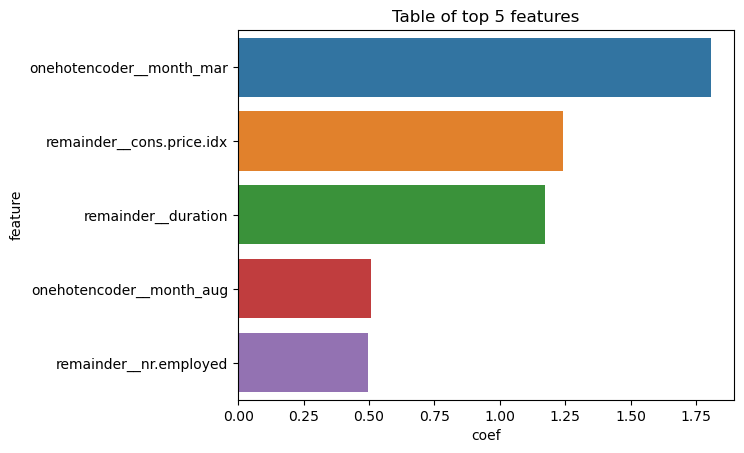

In [16]:
# LogosticRegression basic model coefficients
dflgr = pd.DataFrame({'feature':pipe_lgr.named_steps['txfmr'].get_feature_names_out(), 'coef':pipe_lgr.named_steps['lgr'].coef_[0]})
dflgr = dflgr.sort_values(by='coef', ascending=False)
#dflgr
# data visualization
top5 = dflgr.head(5)
print(top5)
sns.barplot(top5, y='feature', x='coef')
plt.title('Table of top 5 features')

In [17]:
%%time
# KNearestNeighbors basic model
pipe_knn = Pipeline([
    ('txfmr', ctxfmr),
    ('knn', KNeighborsClassifier())])
time1 = datetime.now() 
pipe_knn.fit(X_train, y_train)
duration = (datetime.now() - time1)
print('KNN')
print('train time =', duration.total_seconds(), 'secs')
train_score = pipe_knn.score(X_train, y_train)
print('train accuracy =', train_score)
test_score = pipe_knn.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, pipe_knn.predict(X_test))
print('F1 score =', f1_score)
train_time.append(duration.total_seconds())
train_scores.append(train_score)
test_scores.append(test_score)
f1_scores.append(f1_score)

KNN
train time = 0.100048 secs
train accuracy = 0.922215453821283
test accuracy = 0.887176123319121
F1 score = 0.48605577689243024
CPU times: total: 11.2 s
Wall time: 4.37 s


In [18]:
%%time
# DecisionTree basic model
pipe_dtr = Pipeline([
    ('txfmr', ctxfmr),
    ('dtr', DecisionTreeClassifier())])
time1 = datetime.now() 
pipe_dtr.fit(X_train, y_train)
duration = (datetime.now() - time1)
print('DecisionTree')
print('train time =', duration.total_seconds(), 'secs')
train_score = pipe_dtr.score(X_train, y_train)
print('train accuracy =', train_score)
test_score = pipe_dtr.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, pipe_dtr.predict(X_test))
print('F1 score =', f1_score)
train_time.append(duration.total_seconds())
train_scores.append(train_score)
test_scores.append(test_score)
f1_scores.append(f1_score)

DecisionTree
train time = 0.293789 secs
train accuracy = 1.0
test accuracy = 0.8765715535148136
F1 score = 0.5205944798301486
CPU times: total: 156 ms
Wall time: 421 ms


In [19]:
%%time
# SupportVectorMachine basic model
pipe_svc = Pipeline([
    ('txfmr', ctxfmr),
    ('svc', SVC())])
time1 = datetime.now() 
pipe_svc.fit(X_train, y_train)
duration = (datetime.now() - time1)
print('SVC')
print('train time =', duration.total_seconds(), 'secs')
train_score = pipe_svc.score(X_train, y_train)
print('train accuracy =', train_score)
test_score = pipe_svc.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, pipe_svc.predict(X_test))
print('F1 score =', f1_score)
train_time.append(duration.total_seconds())
train_scores.append(train_score)
test_scores.append(test_score)
f1_scores.append(f1_score)

SVC
train time = 8.881908 secs
train accuracy = 0.9163581837777048
test accuracy = 0.90007652782333
F1 score = 0.5117521367521368
CPU times: total: 21.6 s
Wall time: 31.5 s


### Problem 9: Score the Model

What is the accuracy of your model?

The LogisticRegression basic model has the highest test accuracy 90% and the best F1 score.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [20]:
dfmc = pd.DataFrame({
    'Model': models,
    'Train Time': train_time,
    'Train Accuracy': train_scores,
    'Test Accuracy': test_scores,
    'F1 Score': f1_scores
})
dfmc

,Model,Train Time,Train Accuracy,Test Accuracy,F1 Score
0,LogisticRegression,0.715013,0.900426,0.900732,0.527083
1,KNN,0.100048,0.922215,0.887176,0.486056
2,DecisionTree,0.293789,1.000000,0.876572,0.520594
3,SVC,8.881908,0.916358,0.900077,0.511752


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [21]:
# run permutation importance data analysis
from sklearn.inspection import permutation_importance

result = permutation_importance(pipe_lgr, X_test, y_test, scoring='f1')
pis = pd.Series(result.importances_mean, index=X.columns)
pis.sort_values(ascending=False)

emp.var.rate      0.330443
duration          0.203923
pdays             0.055608
cons.price.idx    0.032624
month             0.030574
contact           0.014316
poutcome          0.008301
job               0.004937
campaign          0.002323
cons.conf.idx     0.000724
day_of_week       0.000561
marital           0.000496
default           0.000000
loan             -0.000055
housing          -0.000676
education        -0.001530
age              -0.002297
previous         -0.002926
euribor3m        -0.041612
nr.employed      -0.044792
dtype: float64

In [22]:
# filter out default and education features because they are not important based on the permutation importance result
X = dfX.drop(columns=['default','education','y'])
y = dfX['y'].map({'no':0, 'yes':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print(X_train.shape, X_test.shape)
ctxfmr = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['job','marital','contact','housing','loan','month','day_of_week','poutcome']), 
    remainder=StandardScaler())
print(ctxfmr)

(21341, 18) (9147, 18)
ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['job', 'marital', 'contact', 'housing',
                                  'loan', 'month', 'day_of_week',
                                  'poutcome'])])


LogisticRegression
        F1 score
Weight          
1       0.530633
2       0.625684
3       0.628335
4       0.628926
5       0.618229
6       0.610837
7       0.602845
8       0.596370
9       0.591597
10      0.586557
The F1 score is highest when the weight is 3 (or 4)


Text(0.5, 1.0, 'LogisticRegression Hyperparameter class weigh vs F1 score')

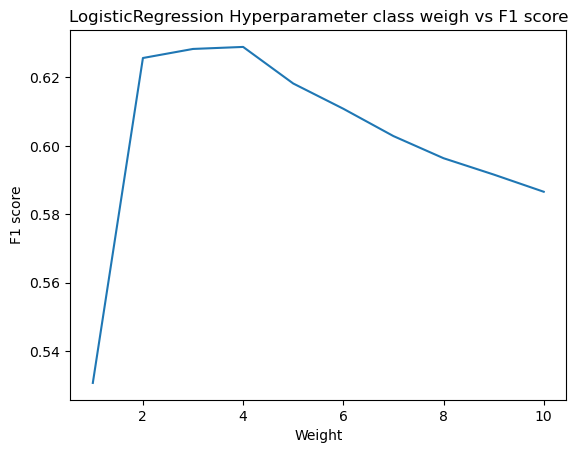

In [23]:
#tune class_weight because the dataset is imbalanced
weights = range(1, 11, 1)
f1_values = []
print('LogisticRegression')
for w in weights:
    #print('weight', w)
    pipe_lgr = Pipeline([
        ('txfmr', ctxfmr),
        ('lgr', LogisticRegression(class_weight={0:1, 1:w}, max_iter=500, random_state=0))])
    pipe_lgr.fit(X_train, y_train)
    f1_score = metrics.f1_score(y_test, pipe_lgr.predict(X_test))
    f1_values.append(f1_score)
dfw = pd.DataFrame({'Weight':weights, 'F1 score':f1_values})
print(dfw.set_index('Weight'))
print('The F1 score is highest when the weight is 3 (or 4)')
sns.lineplot(dfw, x='Weight', y='F1 score')
plt.title('LogisticRegression Hyperparameter class weigh vs F1 score')

In [24]:
# Initialize the table 
train_bscores = []
test_bscores = []
f1_bscores = []

In [25]:
# LogisticRegression GridSearchCV 
params = {'lgr__C': [0.01, 0.1, 1, 10, 100],
          'lgr__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}]}
pipe_lgr = Pipeline([
    ('txfmr', ctxfmr),
    ('lgr', LogisticRegression(max_iter=500))])
grid_lgr = GridSearchCV(estimator=pipe_lgr, scoring='f1', param_grid=params, cv=2)
grid_lgr.fit(X_train, y_train)
print('LogisticRegression')
print(grid_lgr.best_params_)
train_score = grid_lgr.best_estimator_.score(X_train, y_train)
print('train accuracy =', test_score)
test_score = grid_lgr.best_estimator_.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, grid_lgr.best_estimator_.predict(X_test))
print('f1 score =', f1_score)
train_bscores.append(train_score)
test_bscores.append(test_score)
f1_bscores.append(f1_score)

LogisticRegression
{'lgr__C': 0.1, 'lgr__class_weight': {0: 1, 1: 3}}
train accuracy = 0.90007652782333
test accuracy = 0.8931890237236252
f1 score = 0.6311815779539449


In [26]:
# KNearestNeighbors GridSearchCV 
params = {'knn__n_neighbors': [5, 6, 7, 8, 9, 10],
          'knn__weights': ['uniform','distance']}
pipe_knn = Pipeline([
    ('txfmr', ctxfmr),
    ('knn', KNeighborsClassifier())])
grid_knn = GridSearchCV(estimator=pipe_knn, scoring='f1', param_grid=params, cv=2)
grid_knn.fit(X_train, y_train)
print('KNN')
print(grid_knn.best_params_)
train_score = grid_knn.best_estimator_.score(X_train, y_train)
print('train accuracy =', test_score)
test_score = grid_knn.best_estimator_.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, grid_knn.best_estimator_.predict(X_test))
print('f1 score =', f1_score)
train_bscores.append(train_score)
test_bscores.append(test_score)
f1_bscores.append(f1_score)

KNN
{'knn__n_neighbors': 7, 'knn__weights': 'distance'}
train accuracy = 0.8931890237236252
test accuracy = 0.8903465617142232
f1 score = 0.5095354523227384


In [27]:
# DecisionTree GridSearchCV 
params = {'dtr__criterion': ['gini', 'entropy'],
          'dtr__max_depth': [5, 6, 7, 8],
          'dtr__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}]}
pipe_dtr = Pipeline([
    ('txfmr', ctxfmr),
    ('dtr', DecisionTreeClassifier())])
grid_dtr = GridSearchCV(estimator=pipe_dtr, scoring='f1', param_grid=params, cv=2)
grid_dtr.fit(X_train, y_train)
print('DecisionTree')
print(grid_dtr.best_params_)
train_score = grid_dtr.best_estimator_.score(X_train, y_train)
print('train accuracy =', test_score)
test_score = grid_dtr.best_estimator_.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, grid_dtr.best_estimator_.predict(X_test))
print('f1 score =', f1_score)
train_bscores.append(train_score)
test_bscores.append(test_score)
f1_bscores.append(f1_score)

DecisionTree
{'dtr__class_weight': {0: 1, 1: 3}, 'dtr__criterion': 'entropy', 'dtr__max_depth': 5}
train accuracy = 0.8903465617142232
test accuracy = 0.8857548923144201
f1 score = 0.6352530541012216


In [28]:
# SupportVectorMachine GridSearchCV 
params = {'svc__kernel': ['rbf', 'poly'],
          'svc__gamma': ['auto', 'scale'],
          'svc__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}]}
pipe_svc = Pipeline([
    ('txfmr', ctxfmr),
    ('svc', SVC())])
grid_svc = GridSearchCV(estimator=pipe_svc, scoring='f1', param_grid=params, cv=2)
grid_svc.fit(X_train, y_train)
print('SVC')
print(grid_svc.best_params_)
train_score = grid_svc.best_estimator_.score(X_train, y_train)
print('train accuracy =', test_score)
test_score = grid_svc.best_estimator_.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, grid_svc.best_estimator_.predict(X_test))
print('f1 score =', f1_score)
train_bscores.append(train_score)
test_bscores.append(test_score)
f1_bscores.append(f1_score)

SVC
{'svc__class_weight': {0: 1, 1: 3}, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
train accuracy = 0.8857548923144201
test accuracy = 0.884224335847819
f1 score = 0.6391822827938671


### Data Visualization

Text(0.5, 1.0, 'SVC(kernel="rbf") classifier decision boundary plot')

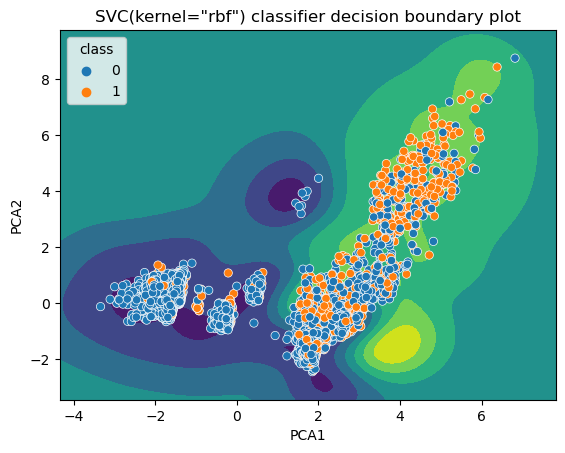

In [29]:
# show the SVC model decision boundary
from sklearn.inspection import DecisionBoundaryDisplay

pca = PCA(n_components=2)
pca.fit(ctxfmr.fit_transform(X_test))
dd = pca.fit_transform(ctxfmr.fit_transform(X_test))
#print(dd)
dfpca = pd.DataFrame({'PCA1':dd[:,0], 'PCA2':dd[:,1]})
mod_svc = SVC(kernel='rbf', gamma='auto', class_weight={0:1, 1:3}).fit(dfpca, y_test)

DecisionBoundaryDisplay.from_estimator(
    estimator=mod_svc, X=dfpca)
dfy = pd.DataFrame({'class':y_test})
sns.scatterplot(dfpca, x=dd[:,0], y=dd[:,1], hue=dfy['class'])
plt.title('SVC(kernel="rbf") classifier decision boundary plot')

In [30]:
# Display the result table after feature engineering and hyperparameters tuning
dfmb = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_bscores,
    'Test Accuracy': test_bscores,
    'F1 Score': f1_bscores
})
dfmb

,Model,Train Accuracy,Test Accuracy,F1 Score
0,LogisticRegression,0.894241,0.893189,0.631182
1,KNN,1.000000,0.890347,0.509535
2,DecisionTree,0.888712,0.885755,0.635253
3,SVC,0.887119,0.884224,0.639182


From the table, SVC is the best model optimized for F1 scores. The top three important features are 'cons.price.idx', 'duration' and 'nr.employed'. That means the monthly consumer price index, previous phone call duration and quarterly employed index are positively correlated to the bank marketing campaign accuracy.

### Summary

We analyzed a Portuguese bank marketing campaign by using supervised machine learning techniques. It is a binary classification problem and its dataset is highly imbalanced. I built and compared four classifier models: LogisticRegression, KNearestNeighbors, DecisionTree and SupportVectorMachine. At the very beginning LogisticRegression is the best model (F1 score = 52.7%) without tuning. After feature engineering and hyperparameters tuning, SupportVerctorMachine is the best model (F1 score = 63.9%) with nonlinear kernel 'rbs'. 

SupportVectorMachine is the best classifier among all because it achieves highest scoring with non-linear kernels. However, it uses a lot of CPU power and can be very slow when the dataset is very large. We can speed up the traing time by using powerful GPU or applying PCA dimension reduction techniques.